<a href="https://colab.research.google.com/github/claredavies/DataEngAPITesting/blob/master/DataEngAPITesting/AnamolyDetection/HTTP_Response/Supervised/Monitor_Latency_StatusCode_Supervised_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [1]:
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
!pip install pyod

from pandas import read_csv
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from pyod.models.mad import MAD
from pyod.models.knn import KNN
from pyod.models.lof import LOF

     |████████████████████████████████| 114 kB 5.2 MB/s 
  Created wheel for pyod: filename=pyod-0.9.8-py3-none-any.whl size=136775 sha256=1860bab11f93f7aadabe775320179606bca98a2020e41517aa8bf86868baabb2
  Stored in directory: /root/.cache/pip/wheels/ba/8f/95/6cb376aec9fae09d9b1622d1662c902b522deb353cb80836a6
Successfully built pyod


# Read in data

In [2]:
train = pd.read_csv("Traffic_train.csv")
test = pd.read_csv("Traffic_test3.csv")
print(train.head())

   Delay  Code  Y
0  15000   302  1
1      0   302  1
2      0   302  1
3  11000   302  1
4  19000   302  1


In [3]:
print(train['Code'].unique())

[302 200 404 400 201 500 204]


# Data Processing

In [4]:
train['Code'].value_counts()

200    5918
201     967
400     670
404     314
204     186
500      36
302      35
Name: Code, dtype: int64

In [5]:
one_hot_encoded_train = pd.get_dummies(train, columns = ['Code'])
print(one_hot_encoded_train)

      Delay  Y  Code_200  Code_201  Code_204  Code_302  Code_400  Code_404  \
0     15000  1         0         0         0         1         0         0   
1         0  1         0         0         0         1         0         0   
2         0  1         0         0         0         1         0         0   
3     11000  1         0         0         0         1         0         0   
4     19000  1         0         0         0         1         0         0   
...     ... ..       ...       ...       ...       ...       ...       ...   
8121  13000  1         1         0         0         0         0         0   
8122  14000  1         1         0         0         0         0         0   
8123  21000  1         1         0         0         0         0         0   
8124  15000  1         1         0         0         0         0         0   
8125  17000  1         1         0         0         0         0         0   

      Code_500  
0            0  
1            0  
2           

In [6]:
train = one_hot_encoded_train[["Delay", "Code_200", "Code_201", "Code_204", "Code_302", "Code_400", "Code_404", "Code_500","Y"]]

In [7]:
print(train.head)

<bound method NDFrame.head of       Delay  Code_200  Code_201  Code_204  Code_302  Code_400  Code_404  \
0     15000         0         0         0         1         0         0   
1         0         0         0         0         1         0         0   
2         0         0         0         0         1         0         0   
3     11000         0         0         0         1         0         0   
4     19000         0         0         0         1         0         0   
...     ...       ...       ...       ...       ...       ...       ...   
8121  13000         1         0         0         0         0         0   
8122  14000         1         0         0         0         0         0   
8123  21000         1         0         0         0         0         0   
8124  15000         1         0         0         0         0         0   
8125  17000         1         0         0         0         0         0   

      Code_500  Y  
0            0  1  
1            0  1  
2        

In [8]:
X_train=train[["Delay", "Code_200", "Code_201", "Code_204", "Code_302", "Code_400", "Code_404", "Code_500"]]
y_train=train[["Y"]]

In [9]:
test = pd.read_csv("Traffic_test3.csv")
one_hot_encoded_test = pd.get_dummies(test, columns = ['Code'])

In [10]:
test = one_hot_encoded_test[["Delay", "Code_200", "Code_201", "Code_204", "Code_302", "Code_400", "Code_404", "Code_500","Y"]]

In [11]:
X_test=test[["Delay", "Code_200", "Code_201", "Code_204", "Code_302", "Code_400", "Code_404", "Code_500"]]
y_test=test[["Y"]]

In [12]:
print(y_train.head())
print(X_train.head())


   Y
0  1
1  1
2  1
3  1
4  1
   Delay  Code_200  Code_201  Code_204  Code_302  Code_400  Code_404  Code_500
0  15000         0         0         0         1         0         0         0
1      0         0         0         0         1         0         0         0
2      0         0         0         0         1         0         0         0
3  11000         0         0         0         1         0         0         0
4  19000         0         0         0         1         0         0         0


In [13]:
y_train.loc[y_train["Y"] == -1, "Y"] = 0
y_test.loc[y_test["Y"] == -1, "Y"] = 0

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


# Metrics

In [14]:
def get_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  return cm

def plot_cm(ax,labels, predictions,title, p=0.5):
  tick_labels = ['Y', 'N']
  cm = get_cm(labels, predictions, p)
  sns.heatmap(cm, annot=True, fmt="d",ax=ax)
  ax.title.set_text(title)
  ax.set_xticklabels(tick_labels)
  ax.set_yticklabels(tick_labels)

# Data Exploration

Anamoly Resampled 8089
Not-Anamoly Resampled 37
Subscribe Resampled proportion 99.54%


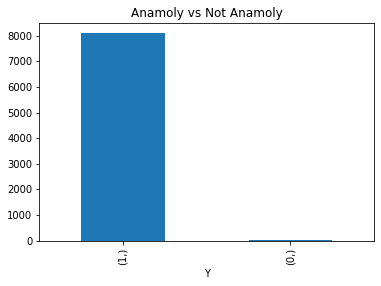

In [15]:
def percentage(part, whole):
  return 100 * float(part) / float(whole)

anamoly, not_anamoly = y_train.value_counts()
print(f'Anamoly Resampled {anamoly}')
print(f'Not-Anamoly Resampled {not_anamoly}')
print(f'Subscribe Resampled proportion {round(percentage(anamoly,anamoly + not_anamoly), 2)}%')

y_train.value_counts().plot(kind="bar", title="Anamoly vs Not Anamoly");

# Resampling

In [16]:
print(y_train['Y'].unique())
print(y_train['Y'].unique())

[1 0]
[1 0]


In [17]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0,  k_neighbors=2)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


Anamoly Resampled 8089
Not-Anamoly Resampled 8089
Subscribe Resampled proportion 50.0%


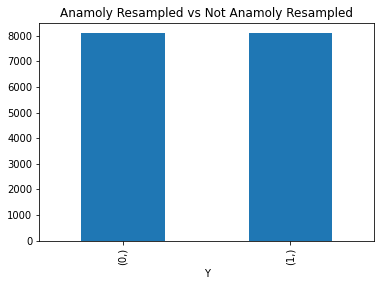

In [18]:
def percentage(part, whole):
  return 100 * float(part) / float(whole)

anamoly_resampled, not_anamoly_resampled = y_train_resampled.value_counts()
print(f'Anamoly Resampled {anamoly_resampled}')
print(f'Not-Anamoly Resampled {not_anamoly_resampled}')
print(f'Subscribe Resampled proportion {round(percentage(anamoly_resampled,anamoly_resampled + not_anamoly_resampled), 2)}%')

y_train_resampled.value_counts().plot(kind="bar", title="Anamoly Resampled vs Not Anamoly Resampled");

In [19]:
print(y_train_resampled.head(100))

    Y
0   1
1   1
2   1
3   1
4   1
.. ..
95  1
96  1
97  1
98  1
99  1

[100 rows x 1 columns]


# Weighting

In [20]:
anamoly_count, not_anamoly_count = np.bincount(y_train.Y)
total_count = len(y_train.Y)

weight_anamoly = ((1 / anamoly_count) * (total_count) / 2.0 )
weight_not_anamoly = (((1 / not_anamoly_count) * (total_count) / 2.0 )) 
print("Anamoly:  " + str(weight_anamoly))
print("Not anamoly:  " + str(weight_not_anamoly))
class_weights = {0: weight_anamoly, 1: weight_not_anamoly}

Anamoly:  109.81081081081082
Not anamoly:  0.5022870564964768


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


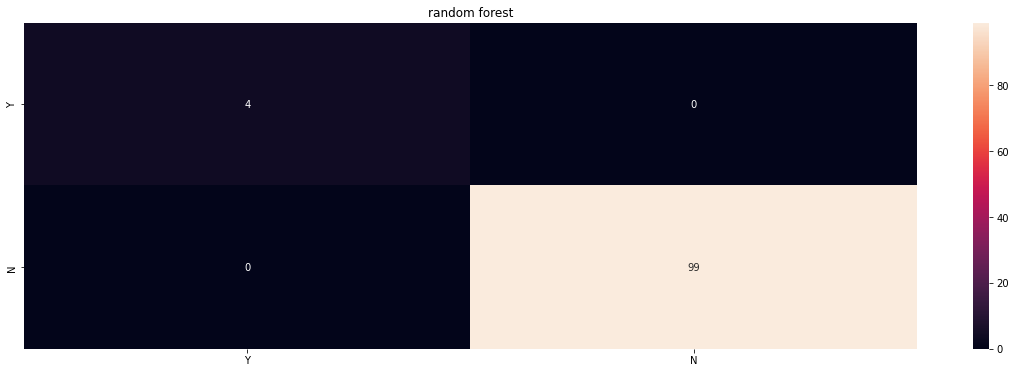

In [22]:
from imblearn.ensemble import BalancedRandomForestClassifier

clf = BalancedRandomForestClassifier(max_depth=2, random_state=0,class_weight=class_weights)
clf.fit(X_train, y_train) 
predictions = clf.predict(X_test)
fig, (ax1) = plt.subplots(1, 1,figsize=(20,6))
plot_cm(ax1,y_test, predictions,"random forest")

# ML

In [29]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

models = {}

# logistic regression does not support imbalanced classification
models['LR'] = LogisticRegression(solver='lbfgs',class_weight=class_weights)
models['RandomForest'] = BalancedRandomForestClassifier(max_depth=2, random_state=0,class_weight=class_weights)


models['KNN'] = KNeighborsClassifier()
models['CART'] = DecisionTreeClassifier()
models['NB'] = GaussianNB()
models['SVM'] = SVC(gamma='auto')

accuracy, precision, recall, predictions = {}, {}, {}, {}
for key in models.keys():
    models[key].fit(X_train, y_train['Y'])
    predictions[key] = models[key].predict(X_test)
    
    accuracy[key] = accuracy_score(predictions[key], y_test['Y'])
    precision[key] = precision_score(predictions[key], y_test['Y'])
    recall[key] = recall_score(predictions[key], y_test['Y'])

TypeError: ignored

              Accuracy  Precision    Recall
LR            0.970874   0.989899  0.980000
LDA           0.970874   1.000000  0.970588
RandomForest  1.000000   1.000000  1.000000
KNN           0.961165   1.000000  0.961165
CART          0.961165   1.000000  0.961165
NB            0.980583   1.000000  0.980198
SVM           0.961165   1.000000  0.961165


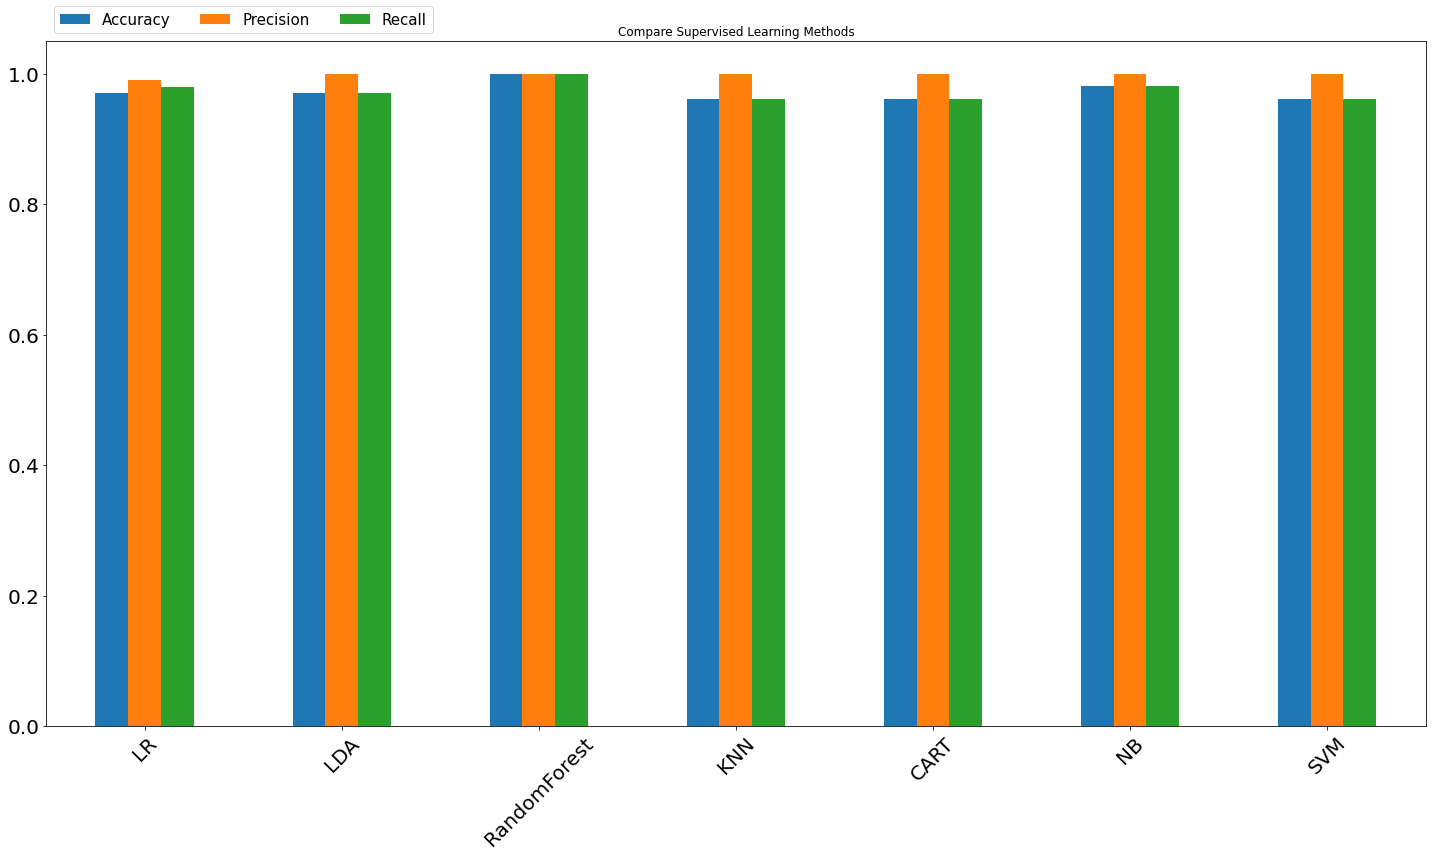

In [28]:
import pandas as pd

df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy'])
df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()

print(df_model)

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
ax  = df_model.plot.bar(rot=45,figsize=(20,12),title="Compare Supervised Learning Methods")
ax.legend(ncol= len(models.keys()), bbox_to_anchor=(0, 1), loc='lower left', prop={'size': 15})
plt.tight_layout()

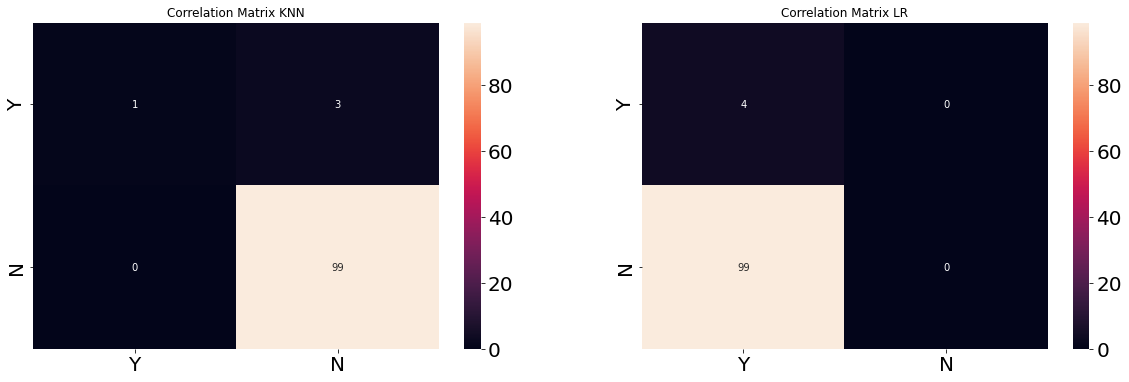

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,6))
plot_cm(ax1,y_test, predictions['KNN'],"Correlation Matrix KNN")
plot_cm(ax2,y_test, predictions['LR'],"Correlation Matrix LR")